# Algorithme de Filtrage collaboratif de chez NetFlix

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

### Initiation de l'ORM Django

In [1]:
import sys
import asyncio
from asgiref.sync import sync_to_async
sys.dont_write_bytecode = True

import os
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'flowAi.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import django
# django.setup()
from django.core.wsgi import get_wsgi_application
application = get_wsgi_application()

In [3]:
from django.contrib.auth.models import User
from stock.models import Track, History
from core.models import UserDetail
from core.serializers import UserDetailSerializer
from stock.serializers.crud_serializers import (TrackSerializer,
                                                HistorySerializer)
TrackSerializer.Meta.depth = 0

In [4]:
track_list = np.array([track.pk for track in Track.objects.all()])
user_list = np.array([user.pk for user in User.objects.all()])
matrix = np.zeros((user_list.size + 1, track_list.size + 1))
matrix[1:, 0] = user_list
matrix[0, 1:] = track_list

In [5]:
class RFC(object):
    
    def __init__(self):
        self.user = User
        self.track = Track
        self.history = History
        
        self.autoencoder = None
    
    def load(self):
        self.track_list = np.array([track.pk for track in self.track.objects.all()])
        self.user_list = np.array([user.pk for user in self.user.objects.all()])
        self.matrix = np.zeros((self.user_list.size + 1, self.track_list.size + 1))
        self.matrix[1:, 0] = self.user_list
        self.matrix[0, 1:] = self.track_list
        
        self.matrice = self.resolve_matrix(self.matrix)
        
        self.train_autoencoder(self.matrice)
        self.matrice = np.append(self.matrice, self.autoencoder.predict([[-1]+[0]*(self.matrice.shape[1]-1)]), axis=0)
        
        self.matrix_similarity = self.resolve_matrix_similarity(self.matrice)
        
        self.index = [self.user.objects.get(pk=i).username for i in self.matrix[1:, 0]] + [-1]
    
    def resolve_matrix(self, matrix):
        for i in range(1, matrix.shape[0]):
            for j in range(1, matrix.shape[1]):
                matrix[i, j] = self.resolve_note(int(matrix[i, 0]), int(matrix[0, j]))
        return matrix
    
    def resolve_note(self, user_pk, track_pk):
        user = self.user.objects.get(pk=user_pk)
        track = self.track.objects.get(pk=track_pk)
        history_user = self.history.objects.filter(user=user, track=track)
        len_history_user = len(history_user)
        if len_history_user==0:
            return 0
        note = np.sum(np.array([history.time/history.track.duration for\
                    history in history_user if history.track!=None]))/len_history_user
        return note
    
    def resolve_matrix_similarity(self, note_matrix):
        matrix_similarity = np.zeros((user_list.size + 2, user_list.size + 2))
        matrix_similarity[1:, 0] = np.append(user_list, [-1])
        matrix_similarity[0, 1:] = np.append(user_list, [-1])
        vect = []
        c = 1
        for i in range(1, note_matrix.shape[0]):
            for j in range(1, note_matrix.shape[0]):
                vect.append(self.cos_similarity_vect(note_matrix[i, 1:],
                                                   note_matrix[j, 1:]))
            matrix_similarity[c, 1:] = np.array(vect)
            c += 1
            vect = []
        return matrix_similarity

    def cos_similarity_vect(self, u, v):
        norm_u = np.sqrt(np.sum(np.power(u, 2)))
        norm_v = np.sqrt(np.sum(np.power(v, 2)))
        dot_uv = np.dot(u, v)
        cos_uv = dot_uv / (norm_u * norm_v) if norm_u * norm_v!=0 else 0
        return cos_uv
    
    def view_note(self):
        index = [self.user.objects.get(pk=i).username for i in matrix[1:, 0]] + [-1]
        df = pd.DataFrame(self.matrice[1:, 1:], columns=[self.track.objects.get(pk=i).title for i\
                                                         in self.matrix[0, 1:]], index=self.index)
        return df.head(10)
    
    def view_similarity(self):
        df1 = pd.DataFrame(self.matrix_similarity[1:, 1:], columns=self.index, index=self.index)
        return df1.head(10)
    
    def view_similarity_colormap(self):
        plt.figure(figsize=(6, 6))
        plt.pcolormesh(np.flip(self.matrix_similarity[1:, 1:], 0), cmap = 'Greens_r')
        plt.colorbar()
        
    def autoencoder_model(self, input_size=784, hidden_size=128, code_size=32):
        input_img = Input(shape=(input_size,))
        hidden_1 = Dense(hidden_size, activation='relu')(input_img)
        code = Dense(code_size, activation='relu')(hidden_1)
        hidden_2 = Dense(hidden_size, activation='relu')(code)
        output_img = Dense(input_size, activation='sigmoid')(hidden_2)

        autoencoder = Model(input_img, output_img)
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        return autoencoder
    
    def train_autoencoder(self, data_train):
        autoencoder = self.autoencoder_model(input_size=data_train.shape[1],
                                             hidden_size=18, code_size=2)
        history = autoencoder.fit(data_train, data_train, verbose=0, epochs=50)
        self.autoencoder = autoencoder
    
    
    def predict(self, user_pk):
        users = self.matrix_similarity[0, 1:]
        matrix_similarity = self.matrix_similarity
        matrice = self.matrice
        vect = matrix_similarity[matrix_similarity[:, 0]==user_pk]
        if vect.size == 0:
            vect = matrix_similarity[matrix_similarity[:, 0]==-1]
        vect = vect[0, 1:]
        track_list = []
        if vect.size != 0:
            vect = np.array([vect, users])
            vect = vect[:, np.argsort(vect[0, :], 0)]
            for user in vect[1, -4:]:
                if user != -1:
                    notes = matrice[matrice[:, 0]==user][0, :].tolist()
                    tracks = matrice[0, :].tolist()
                    note_track = np.array([notes, tracks]).transpose()
                    for i, j in note_track:
                        if i != 0:
                            track_list.append(j)
            return sorted(list(set(track_list)))
        else:
            return 'does not exist'


In [6]:
rcf = RFC()

In [7]:
rcf.load()

In [9]:
rcf.predict(2)

[0.0,
 1.0,
 4.0,
 5.0,
 6.0,
 7.0,
 10.0,
 11.0,
 12.0,
 13.0,
 16.0,
 18.0,
 19.0,
 20.0,
 21.0,
 23.0,
 24.0,
 25.0,
 26.0]

In [9]:
rcf.view_note()

Trop beau  La quete      reve     Manif  Jour meilleur  \
root@root.com     0.664171  0.613504  0.585820  0.497336       0.697725   
root@admin.com    0.000000  0.047376  0.030774  0.000000       0.014492   
admin@admin.com   0.000000  0.057076  0.038351  0.000000       0.000000   
yvan@gmail.com    0.000000  0.000000  0.897254  0.443902       0.000000   
flow@root.com     0.000000  0.000000  0.000000  0.000000       0.000000   
-1                0.486343  0.498187  0.511640  0.516741       0.520562   

                    Flash     Yusuf  Regarde moi  Montfermeil       202  \
root@root.com    0.678265  0.384362     0.845110     0.943827  0.694368   
root@admin.com   0.000000  0.041774     0.000000     0.000000  0.000000   
admin@admin.com  0.000000  0.834087     0.016644     0.000000  0.118958   
yvan@gmail.com   0.222050  0.239560     0.000000     1.321989  0.000000   
flow@root.com    0.950422  0.825134     0.000000     0.000000  0.000000   
-1               0.512876  0.506028     0.522932     0.522403  0.529820   

                 Ne me ramène pas    Verité  Skit roman  Plus de larme  \
root@root.com            0.539921  0.447841    0.316277       0.985792   
root@admin.com           0.000000  0.000000    0.000000       0.000000   
admin@admin.com          0.000000  0.036947    0.000000       0.000000   
yvan@gmail.com           0.298476  0.994764    0.000000       0.432090   
flow@root.com            0.000000  0.000000    0.000000       0.000000   
-1                       0.512426  0.511283    0.516871       0.521189   

                 La pluie  Christophe   Fantome  
root@root.com    0.974367    0.536508  0.000000  
root@admin.com   0.273156    0.040344  0.084513  
admin@admin.com  0.000000    0.000000  0.000000  
yvan@gmail.com   0.000000    0.000000  0.000000  
flow@root.com    0.000000    0.000000  0.883658  
-1               0.525656    0.504753  0.524616

In [10]:
rcf.view_similarity()

root@root.com  root@admin.com  admin@admin.com  \
root@root.com         1.000000        0.446357         0.213532   
root@admin.com        0.446357        1.000000         0.153797   
admin@admin.com       0.213532        0.153797         1.000000   
yvan@gmail.com        0.592347        0.062276         0.157713   
flow@root.com         0.230046        0.238540         0.528806   
-1                    0.929388        0.437789         0.312355   

                 yvan@gmail.com  flow@root.com        -1  
root@root.com          0.592347       0.230046  0.929388  
root@admin.com         0.062276       0.238540  0.437789  
admin@admin.com        0.157713       0.528806  0.312355  
yvan@gmail.com         1.000000       0.130905  0.580713  
flow@root.com          0.130905       1.000000  0.419524  
-1                     0.580713       0.419524  1.000000

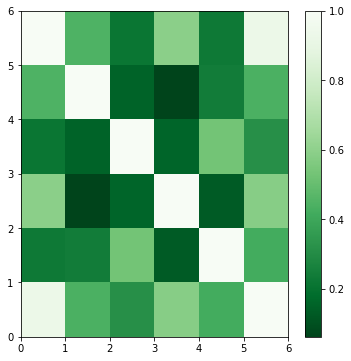

In [11]:
rcf.view_similarity_colormap()